# 1. Installing Dependencies

1.0 Mount Google Drive

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.7.1 tensorflow-gpu==2.7.1 tensorflow-io==0.23.1 opencv-python matplotlib

1.2 Load Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# Section 7
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# 2. Build Data Loading Function


2.1 Define Paths to Files

In [ ]:
CAPUCHIN_FILE = os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Parsed_Capuchinbird_Clips', 'XC114131-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Parsed_Not_Capuchinbird_Clips', 'Crickets-chirping-0.wav')

2.2 Build Dataloading Function

In [ ]:
def load_wav_16k_mono(filename):
  # Load encoded wav file
  file_contents = tf.io.read_file(filename)
  # Decode wav (tensors by channels) 
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  # Removes trailing axis
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Goes from 44100Hz to 16000hz - amplitude of the audio signal
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

2.3 Plot Wave

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

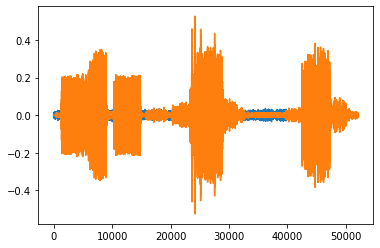

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

3.1 Define Paths to Positive and Negative Data

In [ ]:
POS = os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Parsed_Not_Capuchinbird_Clips')

3.2 Create Tensorflow Datasets

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

3.3 Add labels and Combine and Negative Samples

In [ ]:
# Flag capuchin bird calls as 1, non as 0
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

4.1 Calculate Wave Cycle Length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_16k_mono(os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Parsed_Capuchinbird_Clips', file))
  lengths.append(len(tensor_wave))


4.2 Calculate statistics

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

5.1 Build Preprocessing Function

In [ ]:
def preprocess(file_path, label):
  # Load data into wave form
  wav = load_wav_16k_mono(file_path)
  # Grab 48000 sample length from each signal
  wav = wav[:48000]
  # Pad any clip that doesn't meet 48000 with zeros
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  # Concatenate zeros + wave file
  wav = tf.concat([zero_padding, wav], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  # Get rid of negatives
  spectrogram = tf.abs(spectrogram)
  # Encapsulate spectrogram in another set of arrays
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label


5.2 Test Out the Function and Visualize the Spectrogram

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

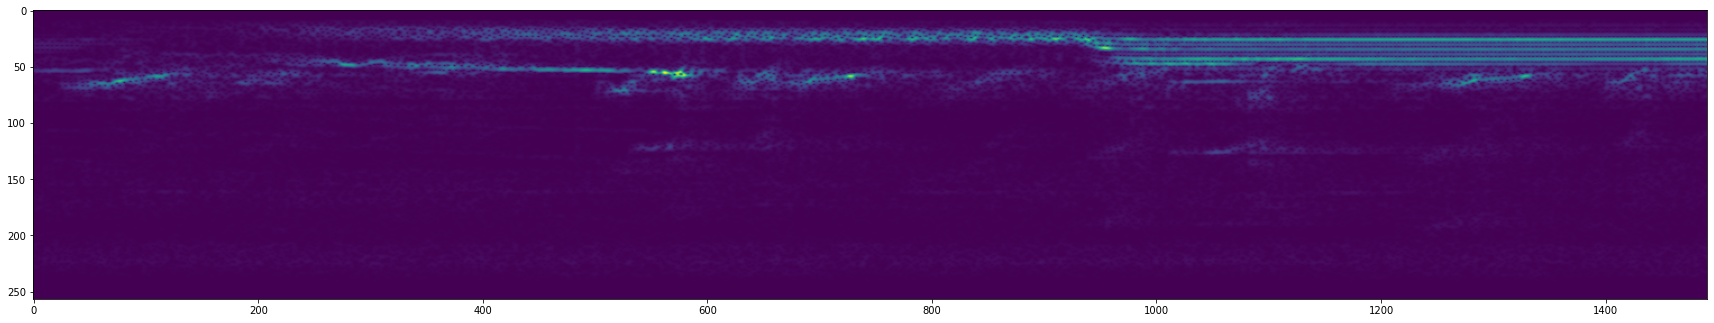

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

6.1 Create a Tensorflow Data Pipeline

In [ ]:
# Takes file_path, label and outputs spectrogram and label
data = data.map(preprocess)
data = data.cache()
# Shuffle to ensure variance
data = data.shuffle(buffer_size=1000)
# Train on 16 samples at a time
data = data.batch(16)
# Prefetch 8 examples to eliminate CPU bottlenecking
data = data.prefetch(8)

6.2 Split into Training and Testing Partitions

In [ ]:
train = data.take(36) # 70% of data
test = data.skip(36).take(15) # 30% of data

6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

7.1 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
# Same shape as spectrogram
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Flatten convulational outputs in 3-dimensions into 1 dimension
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
# Could use max pooling to optimize parameters
model.summary()

7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=6, validation_data=test)

Epoch 1/6
36/36 [==============================] - 156s 4s/step - loss: 0.0497 - recall: 0.9745 - precision: 0.9871 - val_loss: 0.0099 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/6
36/36 [==============================] - 148s 4s/step - loss: 0.0466 - recall: 0.9935 - precision: 0.9747 - val_loss: 0.0197 - val_recall: 0.9818 - val_precision: 1.0000
Epoch 3/6
36/36 [==============================] - 144s 4s/step - loss: 0.0322 - recall: 0.9937 - precision: 0.9753 - val_loss: 0.0172 - val_recall: 0.9831 - val_precision: 1.0000
Epoch 4/6
36/36 [==============================] - 148s 4s/step - loss: 0.0136 - recall: 0.9932 - precision: 1.0000 - val_loss: 0.0068 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/6
36/36 [==============================] - 148s 4s/step - loss: 0.0054 - recall: 0.9935 - precision: 1.0000 - val_loss: 0.0046 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/6
36/36 [==============================] - 146s 4s/step - loss: 0.0020 - recall: 1.0000 - pr

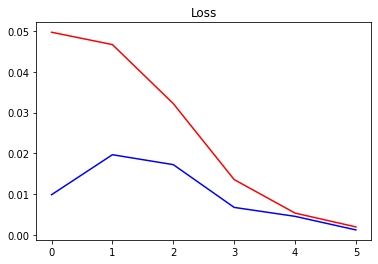

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

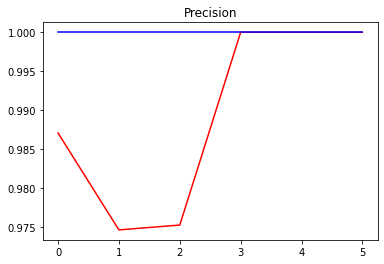

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

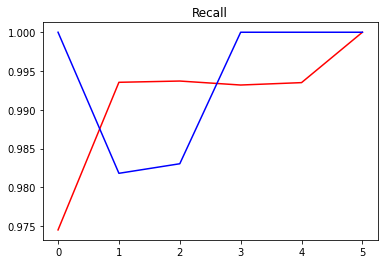

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

8.1 Get One Batch and Make a Prediction

In [ ]:
# X_test are spectrograms for original clips
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

8.2 Convert Logits (Confidence Metrics) to Classes

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]

In [ ]:
# Test if yhat aligns with test batch
y_test.astype(int)

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0])

# 9. Build Forest Parsing Functions

9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
  res = tfio.audio.AudioIOTensor(filename)
  # Convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1)/2
  # Extract sample rate and cast
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Resample to 16 kHz
  wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
  return wav

In [ ]:
mp3 = os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
# Slices each clip into multiple slices
# Each slice will be converted to a spectrogram
# Model will predict based on each spectrogram

audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram

9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

5

# 10. Make Predictions

10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Forest Recordings')):
  FILEPATH = os.path.join('/content/gdrive/MyDrive/Code/ML/Z by HP Unlocked Challenge 3 - Signal Processing/Data', 'Forest Recordings', file)

  wav = load_mp3_16k_mono(FILEPATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  yhat = model.predict(audio_slices)

  results[file] = yhat

10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
  class_preds[file] = [1 if prediction > 0.999 else 0 for prediction in logits]
class_preds

10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
  postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11 Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
  writer = csv.writer(f, delimiter=',')
  writer.writerow(['recording', 'capuchin_calls'])
  for key, value in postprocessed.items():
    writer.writerow([key, value])

# 12. Save Model

In [ ]:
from keras.models import load_model

In [ ]:
model.save(os.path.join('/content/gdrive/MyDrive/Code/ML/Models', 'CapuchinBirdCall.h5'))

In [ ]:
new_model = load_model(os.path.join('/content/gdrive/MyDrive/Code/ML/Models', 'CapuchinBirdCall.h5'))

12.1 Test Model Works

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = new_model.predict(X_test)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]

In [ ]:
y_test.astype(int)

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0])